In [1]:
%matplotlib inline

import time
import datetime

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

from scipy.optimize import curve_fit
from jupyterthemes import jtplot

jtplot.style(theme='onedork')

In [2]:
# Data from:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [3]:
df = pd.read_csv(url, index_col=[0,1])
df

Lat       Long  \
Province/State            Country/Region                                
NaN                       Afghanistan            33.000000  65.000000   
                          Albania                41.153300  20.168300   
                          Algeria                28.033900   1.659600   
                          Andorra                42.506300   1.521800   
                          Angola                -11.202700  17.873900   
...                                                    ...        ...   
Saint Pierre and Miquelon France                 46.885200 -56.315900   
NaN                       South Sudan             6.877000  31.307000   
                          Western Sahara         24.215500 -12.885800   
                          Sao Tome and Principe   0.186360   6.613081   
                          Yemen                  15.552727  48.516388   

                                                 1/22/20  1/23/20  1/24/20  \
Province/State            Country/Region                                     
NaN                       Afghanistan                  0        0        0   
                          Albania                      0        0        0   
                          Algeria                      0        0        0   
                          Andorra                      0        0        0   
                          Angola                       0        0        0   
...                                                  ...      ...      ...   
Saint Pierre and Miquelon France                       0        0        0   
NaN                       South Sudan                  0        0        0   
                          Western Sahara               0        0        0   
                          Sao Tome and Principe        0        0        0   
                          Yemen                        0        0        0   

                                                 1/25/20  1/26/20  1/27/20  \
Province/State            Country/Region                                     
NaN                       Afghanistan                  0        0        0   
                          Albania                      0        0        0   
                          Algeria                      0        0        0   
                          Andorra                      0        0        0   
                          Angola                       0        0        0   
...                                                  ...      ...      ...   
Saint Pierre and Miquelon France                       0        0        0   
NaN                       South Sudan                  0        0        0   
                          Western Sahara               0        0        0   
                          Sao Tome and Principe        0        0        0   
                          Yemen                        0        0        0   

                                                 1/28/20  1/29/20  ...  \
Province/State            Country/Region                           ...   
NaN                       Afghanistan                  0        0  ...   
                          Albania                      0        0  ...   
                          Algeria                      0        0  ...   
                          Andorra                      0        0  ...   
                          Angola                       0        0  ...   
...                                                  ...      ...  ...   
Saint Pierre and Miquelon France                       0        0  ...   
NaN                       South Sudan                  0        0  ...   
                          Western Sahara               0        0  ...   
                          Sao Tome and Principe        0        0  ...   
                          Yemen                        0        0  ...   

                                                 4/9/20  4/10/20  4/11/20  \
Province/State            Country/R

In [4]:
df2 = df.drop(['Lat', 'Long'], 1).groupby(level=1).sum().T
df2.index = pd.to_datetime(df2.index)
last_date = df2.index[-1]

df2

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-14,23,24,326,31,2,2,102,16,62,384,...,12129,8,4,9,0,2,0,0,2,3
2020-04-15,25,25,336,33,2,2,111,17,63,393,...,12894,8,4,9,0,2,0,0,2,3
2020-04-16,30,26,348,33,2,3,115,18,63,410,...,13759,9,4,9,0,2,0,0,2,3
2020-04-17,30,26,364,35,2,3,123,19,66,431,...,14607,9,4,9,0,2,0,0,2,3


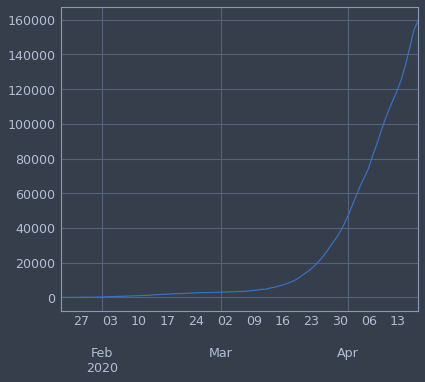

In [5]:
df2.T.sum().plot()

In [6]:
len(df2.columns)

185

In [7]:
df_exchina = df2.drop('China', 1)

df_exchina = df_exchina[df_exchina.T.sum() > 1]
len(df_exchina.columns)

184

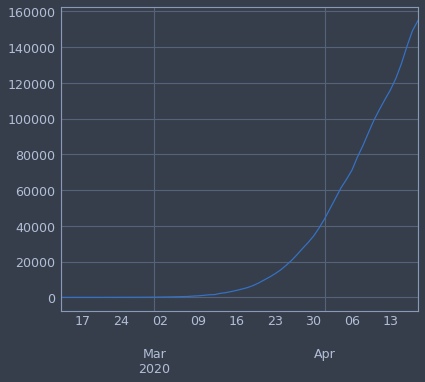

In [8]:
df_exchina.T.sum().plot()

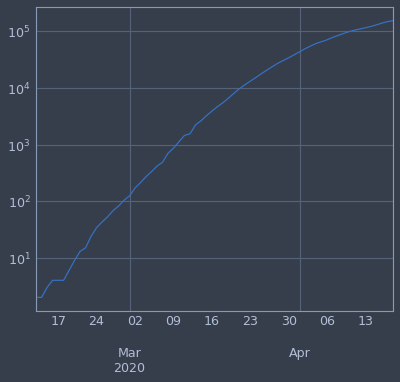

In [9]:
df_exchina.T.sum().plot(logy = True)

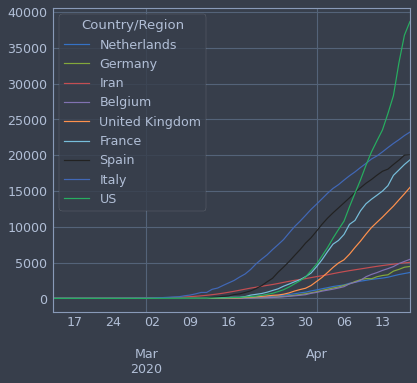

In [10]:
df_exchina.T.sort_values(by=last_date).tail(9).T.plot()

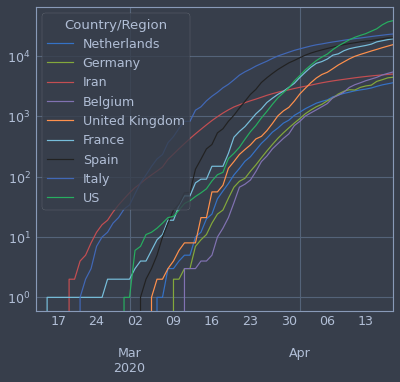

In [11]:
df_exchina.T.sort_values(by=last_date).tail(9).T.plot(logy = True)

In [12]:
df_exchina.T.sort_values(by=last_date).tail(9).T.tail(10)

Country/Region,Netherlands,Germany,Iran,Belgium,United Kingdom,France,Spain,Italy,US
2020-04-09,2403,2607,4110,2523,7993,12228,15447,18279,16544
2020-04-10,2520,2767,4232,3019,8974,13215,16081,18849,18586
2020-04-11,2653,2736,4357,3346,9892,13851,16606,19468,20462
2020-04-12,2747,3022,4474,3600,10629,14412,17209,19899,22019
2020-04-13,2833,3194,4585,3903,11347,14986,17756,20465,23528
2020-04-14,2955,3294,4683,4157,12129,15748,18056,21067,25831
2020-04-15,3145,3804,4777,4440,12894,17188,18708,21645,28325
2020-04-16,3327,4052,4869,4857,13759,17941,19315,22170,32916
2020-04-17,3471,4352,4958,5163,14607,18703,20002,22745,36773
2020-04-18,3613,4459,5031,5453,15498,19345,20043,23227,38664


In [13]:
df_exchina.T.sort_values(by=last_date).tail(9).T.diff().tail(10)

Country/Region,Netherlands,Germany,Iran,Belgium,United Kingdom,France,Spain,Italy,US
2020-04-09,148.0,258.0,117.0,283.0,882.0,1341.0,655.0,610.0,1849.0
2020-04-10,117.0,160.0,122.0,496.0,981.0,987.0,634.0,570.0,2042.0
2020-04-11,133.0,-31.0,125.0,327.0,918.0,636.0,525.0,619.0,1876.0
2020-04-12,94.0,286.0,117.0,254.0,737.0,561.0,603.0,431.0,1557.0
2020-04-13,86.0,172.0,111.0,303.0,718.0,574.0,547.0,566.0,1509.0
2020-04-14,122.0,100.0,98.0,254.0,782.0,762.0,300.0,602.0,2303.0
2020-04-15,190.0,510.0,94.0,283.0,765.0,1440.0,652.0,578.0,2494.0
2020-04-16,182.0,248.0,92.0,417.0,865.0,753.0,607.0,525.0,4591.0
2020-04-17,144.0,300.0,89.0,306.0,848.0,762.0,687.0,575.0,3857.0
2020-04-18,142.0,107.0,73.0,290.0,891.0,642.0,41.0,482.0,1891.0


In [14]:
df_exchina.T.sort_values(by=last_date).tail(9).T.diff().diff().tail(10)

Country/Region,Netherlands,Germany,Iran,Belgium,United Kingdom,France,Spain,Italy,US
2020-04-09,1.0,-75.0,-4.0,78.0,-58.0,797.0,-92.0,68.0,-52.0
2020-04-10,-31.0,-98.0,5.0,213.0,99.0,-354.0,-21.0,-40.0,193.0
2020-04-11,16.0,-191.0,3.0,-169.0,-63.0,-351.0,-109.0,49.0,-166.0
2020-04-12,-39.0,317.0,-8.0,-73.0,-181.0,-75.0,78.0,-188.0,-319.0
2020-04-13,-8.0,-114.0,-6.0,49.0,-19.0,13.0,-56.0,135.0,-48.0
2020-04-14,36.0,-72.0,-13.0,-49.0,64.0,188.0,-247.0,36.0,794.0
2020-04-15,68.0,410.0,-4.0,29.0,-17.0,678.0,352.0,-24.0,191.0
2020-04-16,-8.0,-262.0,-2.0,134.0,100.0,-687.0,-45.0,-53.0,2097.0
2020-04-17,-38.0,52.0,-3.0,-111.0,-17.0,9.0,80.0,50.0,-734.0
2020-04-18,-2.0,-193.0,-16.0,-16.0,43.0,-120.0,-646.0,-93.0,-1966.0


In [15]:
def sigmoid(x, sat, td, velo):
    x = np.float64(x)
    
    td *= 1e10
    td *= 1e9
    
    real_sat = 1e5 * sat
    x = x - td
    x /= 1e14
    return real_sat / (1 + np.exp(-x * velo))

x = df_exchina.index
sat = 30000 / 1e5
td = time.time() / 1e10
velo = .1

In [16]:
popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_exchina.index, 
                       ydata = df_exchina.T.sum(), 
                       p0 = (sat, td, velo)
                      )

In [17]:
y_fit = sigmoid(x, *list(popt))

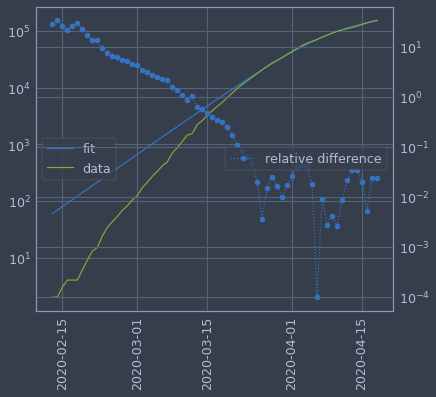

In [18]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)


ax1.semilogy(x, y_fit, label="fit")
ax1.semilogy(x, df_exchina.T.sum(), label="data")

ax2 = ax1.twinx()
ax2.semilogy(x, abs(y_fit - df_exchina.T.sum())/df_exchina.T.sum(), "o:", label="relative difference")
# ax1.legend(loc="lower left")
# ax2.legend(loc="center left")
ax1.legend(loc="center left")
ax2.legend(loc="center right")

In [19]:
th = datetime.datetime.fromtimestamp(popt[1] * 1e10)

In [20]:
f'The total number of Deaths outside China due to Covid-19 will be {int(popt[0] * 1e5)}. Half of those will be reached at {th.strftime("%Y-%B-%d %H:%M")}'

'The total number of Deaths outside China due to Covid-19 will be 201635. Half of those will be reached at 2020-April-10 08:20'

In [21]:
th - df_exchina.index[-1]

Timedelta('-8 days +08:20:43.409716')

In [22]:
df_exchina.T.sum().tail()

2020-04-14    122638
2020-04-15    130830
2020-04-16    140454
2020-04-17    149185
2020-04-18    154873
dtype: int64

In [23]:
df_exchina.T.sum().diff().tail(10)

2020-04-09    7181.0
2020-04-10    7003.0
2020-04-11    5974.0
2020-04-12    5588.0
2020-04-13    5389.0
2020-04-14    6502.0
2020-04-15    8192.0
2020-04-16    9624.0
2020-04-17    8731.0
2020-04-18    5688.0
dtype: float64

In [24]:
tstart = min(df_exchina.index)
tend = tstart + (th - tstart) * 2

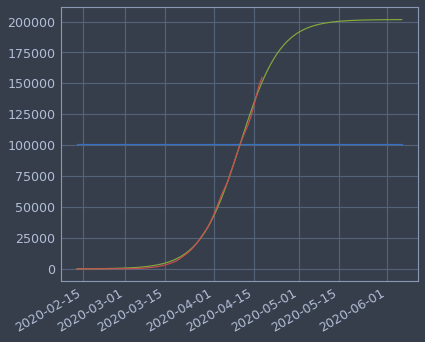

In [25]:
x_extra = np.arange(tstart, tend, datetime.timedelta(days=1)).astype('datetime64[ns]')
y_extra = sigmoid(x_extra, *list(popt))

plt.plot(x_extra, [popt[0]/2 * 1e5 for _ in x_extra])
plt.plot(x_extra, y_extra)
df_exchina.T.sum().plot()
plt.show()

(array([737470., 737485., 737499., 737516., 737530.]),
 <a list of 5 Text major ticklabel objects>)

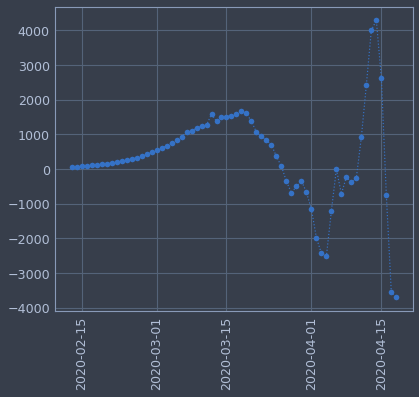

In [26]:
plt.plot(df_exchina.index, y_fit - df_exchina.T.sum(), ":o")
plt.xticks(rotation=90)

In [27]:
x = []
y_var = []
y = []
h = []

for e in df_exchina.index[30:]:
    df_temp = df_exchina[:e]
    
    popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_temp.index, 
                       ydata = df_temp.T.sum(), 
                       p0 = (sat, td, velo)
                      )
    
    x.append(e + datetime.timedelta(days=1))
    y_var.append(np.diag(pcov)[1] * 1e10)
    y.append(datetime.datetime.fromtimestamp(popt[1] * 1e10))
    h.append(int(popt[0] * 1e5))
    

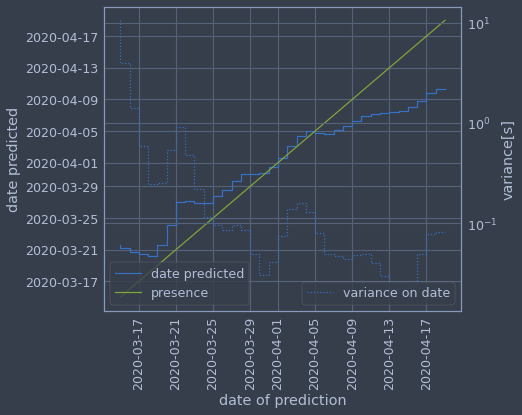

In [28]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)
plt.xlabel("date of prediction")

plt.ylabel("date predicted")

ax1.plot(x, y, label='date predicted', drawstyle='steps')
ax1.plot(x, x, label='presence')


ax2 = ax1.twinx()
ax2.semilogy(x, y_var, ":", label='variance on date', drawstyle='steps')
plt.ylabel("variance[s]")

ax1.legend(loc="lower left")
ax2.legend(loc="lower right")

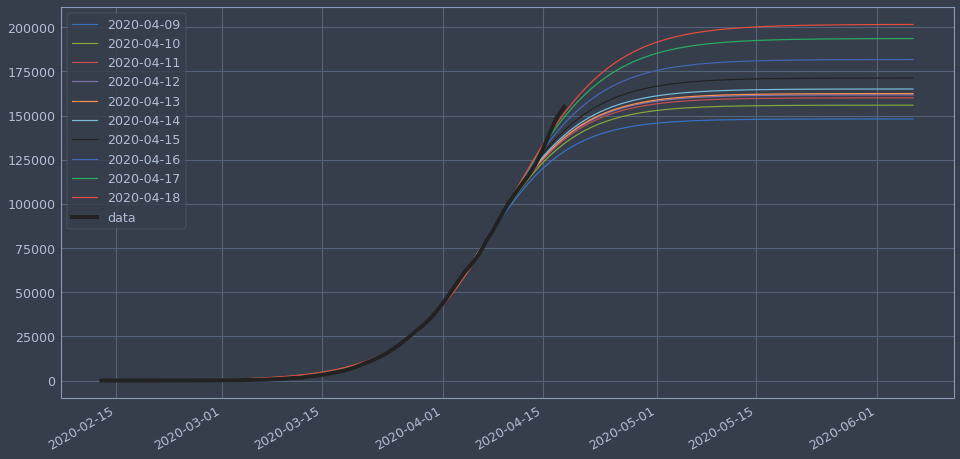

In [29]:
for e in df_exchina.index[-10:]:#[30:]:
    df_temp = df_exchina[:e]
    
    popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_temp.index, 
                       ydata = df_temp.T.sum(), 
                       p0 = (sat, td, velo)
                      )
    y_extra = sigmoid(x_extra, *list(popt))

    plt.plot(x_extra, y_extra, label=e.strftime("%Y-%m-%d"))
df_exchina.T.sum().plot(linewidth=4, style="k", label="data", figsize=(16,8))
plt.legend(loc="upper left")
plt.show()
    

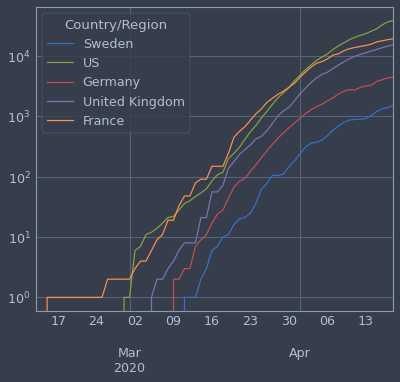

In [30]:
df_exchina[["Sweden", "US", "Germany", "United Kingdom", "France"]].plot(logy=True)